In [1]:
pip install assemblyai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import assemblyai as aai

In [8]:
import assemblyai as aai
import requests
import librosa
import numpy as np

aai.settings.api_key = "0bf39fe2e1dd44ffa91dff2aadbff76a"
transcriber = aai.Transcriber()

transcript = transcriber.transcribe("/kaggle/input/boththetypes/drive-download-20250415T081118Z-001 (1)/drive-download-20250415T172326Z-001/Angela Lansbury/Angela Lansbury_1.wav")

y, sr = librosa.load("/kaggle/input/boththetypes/drive-download-20250415T081118Z-001 (1)/drive-download-20250415T172326Z-001/Angela Lansbury/Angela Lansbury_1.wav", sr=None)
duration = librosa.get_duration(y=y, sr=sr)

words = transcript.words
hesitations = {'uh', 'um', 'hmm'}
annotated = []
prev_end = 0

prev_phrases_2 = []
prev_phrases_3 = []

long_pauses = []
hesitation_count = 0
repetition_count = 0
phrase_repetition_count = 0

for i, word_obj in enumerate(words):
    word = word_obj.text.strip().lower()
    start = word_obj.start / 1000.0
    end = word_obj.end / 1000.0
    pause = start - prev_end

    tags = []

    
    if pause > 1.2:
        long_pauses.append(pause)
        tags.append("[pause]")

    if word in hesitations:
        hesitation_count += 1
        tags.append(f"[{word}]")

    
    if i > 0 and word == words[i-1].text.strip().lower():
        repetition_count += 1
        tags.append("[repetition]")

    
    if i > 1:
        phrase_2 = (words[i-2].text.strip().lower(), words[i-1].text.strip().lower())
        if phrase_2 in prev_phrases_2:
            phrase_repetition_count += 1
            tags.append("[phrase repetition]")
        prev_phrases_2.append(phrase_2)
        if len(prev_phrases_2) > 20:
            prev_phrases_2.pop(0)

    
    if i > 2:
        phrase_3 = (words[i-3].text.strip().lower(), words[i-2].text.strip().lower(), words[i-1].text.strip().lower())
        if phrase_3 in prev_phrases_3:
            phrase_repetition_count += 1
            tags.append("[phrase repetition]")
        prev_phrases_3.append(phrase_3)
        if len(prev_phrases_3) > 20:
            prev_phrases_3.pop(0)

    
    annotated.append(f"{word} {' '.join(tags)}".strip())
    prev_end = end

# Speech rate (WPM)
total_words = len(words)
wpm = (total_words / duration) * 60

# Pitch variability
pitches, magnitudes = librosa.piptrack(y=y, sr=sr)
pitch_values = pitches[magnitudes > np.median(magnitudes)]
pitch_std = np.std(pitch_values)

# Incomplete sentence detection
annotated_text = " ".join(annotated)
sentences = annotated_text.split(".")
final_output = []
incomplete_sentence_count = 0

for s in sentences:
    s = s.strip()
    if not s:
        continue
    if not s.endswith(('.', '?', '!')):
        s += " [incomplete sentence]"
        incomplete_sentence_count += 1
    final_output.append(s)

# Calculate essential metrics
total_pauses = len(long_pauses)
pauses_per_minute = (total_pauses / duration) * 60
hesitation_rate = (hesitation_count / total_words) * 100
repetition_rate = ((repetition_count + phrase_repetition_count) / total_words) * 100
incomplete_sentence_rate = (incomplete_sentence_count / len(sentences)) * 100


print("\n--- Annotated Transcript ---\n")
print(".\n".join(final_output))

print("\n--- Speech Metrics for Cognitive Impairment Detection ---")
print(f"Total number of pauses: {total_pauses}")
print(f"Pauses per minute: {round(pauses_per_minute, 2)}")
print(f"Repetition rate: {round(repetition_rate, 2)}%")
print(f"Speech Rate: {round(wpm, 2)} words/minute")
print(f"Pitch Variability (std): {round(pitch_std, 2)}")
print(f"Incomplete sentence rate: {round(incomplete_sentence_rate, 2)}%")



--- Annotated Transcript ---

because of course, i'd always been associated with movies and playing a [pause] certain kind of lady in the movies [incomplete sentence].
i don't like to talk about them as being heavies because they weren't really [incomplete sentence].
they were all characters and interesting [incomplete sentence].
they had an edge to them, some of them more so than others [incomplete sentence].
and i suppose i had that label of being a very strong dramatic actress, you know [incomplete sentence].
so when i had the [phrase repetition] chance to do mame, it was just a complete switch of characters again [incomplete sentence].
mame was a character, what a devil may care [incomplete sentence].
charming, vivacious, effervescent person she was [incomplete sentence].
and certainly i'd never played that [incomplete sentence].
so that was the thing that really sort of set me up on broadway was mame [incomplete sentence].
and thank goodness it was because i played her not many t

In [4]:
def classify_cognitive_risk(pause_rate, repetition_rate, wpm, pitch_std, incomplete_rate):
    score = 0

    if pause_rate > 5:
        score += 1
    if repetition_rate > 5:
        score += 1
    if wpm < 100 or wpm > 190:
        score += 1
    if pitch_std < 30:
        score += 1
    if incomplete_rate > 50:
        score += 1

    if score <= 1:
        return "Low Risk"
    elif score == 2 or score == 3:
        return "Moderate Risk"
    else:
        return "High Risk"


In [5]:
risk_level = classify_cognitive_risk(
    pause_rate=pauses_per_minute,
    repetition_rate=repetition_rate,
    wpm=wpm,
    pitch_std=pitch_std,
    incomplete_rate=incomplete_sentence_rate
)

print(f" Cognitive Risk Level: {risk_level}")


 Cognitive Risk Level: Low Risk


In [6]:
import os
import librosa
import numpy as np
import pandas as pd

np.complex = complex
np.float = float

def extract_audio_features(file_path):
    try:
        y, sr = librosa.load(file_path, sr=None)
        mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
        spec_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
        return np.hstack([mfccs, chroma, spec_contrast, tonnetz])
    except Exception as e:
        print(f"Error with {file_path}: {e}")
        return None

features = []
for root, dirs, files in os.walk("/kaggle/input/boththetypes"):
    for file in files:
        if file.endswith('.wav'):
            full_path = os.path.join(root, file)
            feature_vector = extract_audio_features(full_path)
            if feature_vector is not None:
                subject = os.path.basename(root)
                features.append([subject, file] + feature_vector.tolist())

columns = ['subject', 'file'] + \
          [f'mfcc_{i}' for i in range(13)] + \
          [f'chroma_{i}' for i in range(12)] + \
          [f'spec_contrast_{i}' for i in range(7)] + \
          [f'tonnetz_{i}' for i in range(6)]

df = pd.DataFrame(features, columns=columns)
df.to_csv("cognitive_impairment_audio_features.csv", index=False)


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.71      1.00      0.83         5

    accuracy                           0.75         8
   macro avg       0.86      0.67      0.67         8
weighted avg       0.82      0.75      0.71         8

Percentage Accuracy: 75.00%
Confusion Matrix:


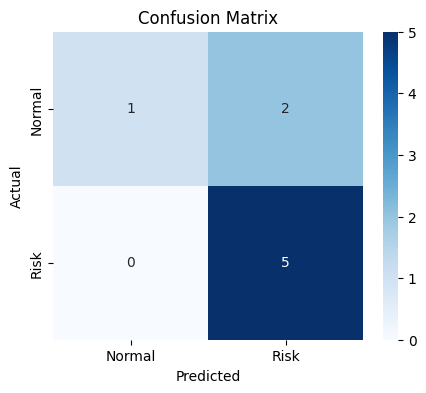

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/kaggle/working/cognitive_impairment_audio_features.csv")

subjects = df['subject'].unique()
risk_subjects = set(subjects[:len(subjects)//2])
df['label'] = df['subject'].apply(lambda x: 1 if x in risk_subjects else 0)

X = df.drop(columns=['subject', 'file', 'label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm = SVC(kernel='rbf', C=1.0, gamma='scale')
svm.fit(X_train_scaled, y_train)

y_pred = svm.predict(X_test_scaled)

print("Classification Report:\n", classification_report(y_test, y_pred))
print(f"Percentage Accuracy: {accuracy_score(y_test, y_pred)*100:.2f}%")
print("Confusion Matrix:")

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Risk"], yticklabels=["Normal", "Risk"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


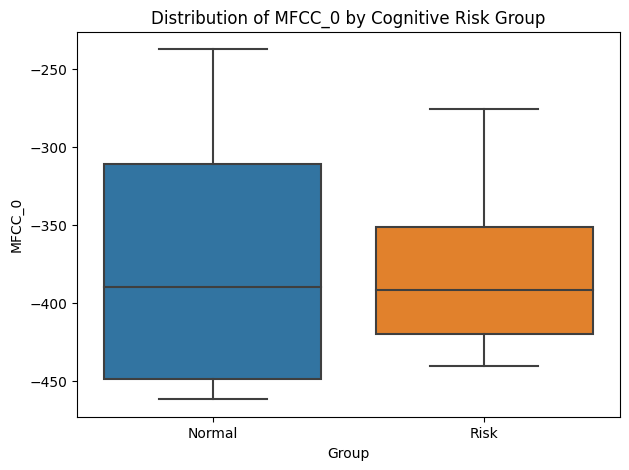

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,5))
sns.boxplot(x='label', y='mfcc_0', data=df)
plt.xticks([0,1], ['Normal', 'Risk'])
plt.title('Distribution of MFCC_0 by Cognitive Risk Group')
plt.xlabel('Group')
plt.ylabel('MFCC_0')
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


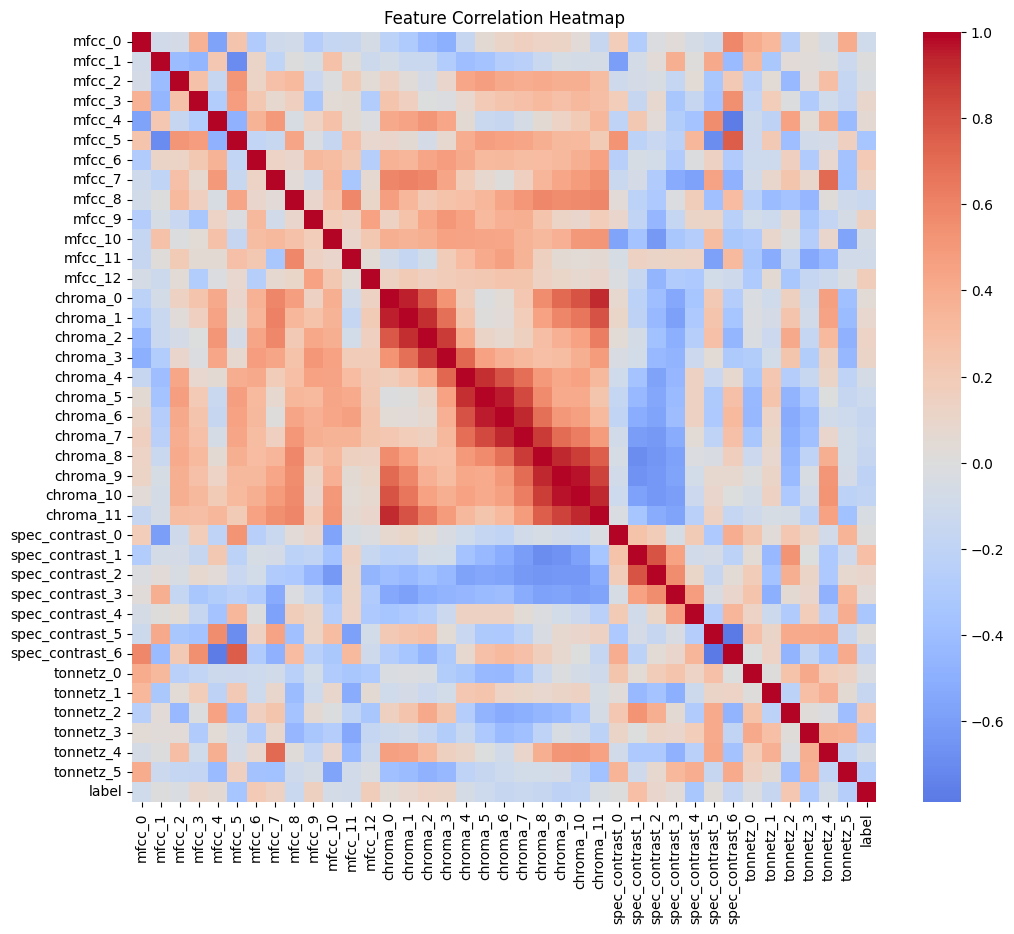

In [13]:
import numpy as np

plt.figure(figsize=(12,10))
corr = df.drop(columns=['subject', 'file']).corr()
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()
